<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#高维二次样条回归" data-toc-modified-id="高维二次样条回归-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>高维二次样条回归</a></span><ul class="toc-item"><li><span><a href="#一元二次（自然）样条函数" data-toc-modified-id="一元二次（自然）样条函数-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>一元二次（自然）样条函数</a></span></li><li><span><a href="#高维样条函数" data-toc-modified-id="高维样条函数-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>高维样条函数</a></span></li><li><span><a href="#光滑二次样条" data-toc-modified-id="光滑二次样条-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>光滑二次样条</a></span></li><li><span><a href="#Loss函数" data-toc-modified-id="Loss函数-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Loss函数</a></span></li><li><span><a href="#实现" data-toc-modified-id="实现-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>实现</a></span></li><li><span><a href="#NestingRegression" data-toc-modified-id="NestingRegression-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>NestingRegression</a></span></li></ul></li><li><span><a href="#1D" data-toc-modified-id="1D-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1D</a></span><ul class="toc-item"><li><span><a href="#1-knot" data-toc-modified-id="1-knot-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1 knot</a></span></li><li><span><a href="#2-knots" data-toc-modified-id="2-knots-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2 knots</a></span></li><li><span><a href="#3-knots" data-toc-modified-id="3-knots-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>3 knots</a></span></li><li><span><a href="#L2正则化参数-$\alpha$" data-toc-modified-id="L2正则化参数-$\alpha$-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>L2正则化参数 $\alpha$</a></span></li><li><span><a href="#光滑正则化参数$\alpha_c$" data-toc-modified-id="光滑正则化参数$\alpha_c$-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>光滑正则化参数$\alpha_c$</a></span></li><li><span><a href="#高密度knots" data-toc-modified-id="高密度knots-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>高密度knots</a></span></li><li><span><a href="#$\exp(x\cos(3\pi-x))$" data-toc-modified-id="$\exp(x\cos(3\pi-x))$-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>$\exp(x\cos(3\pi x))$</a></span></li></ul></li><li><span><a href="#2D-fit" data-toc-modified-id="2D-fit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2D fit</a></span><ul class="toc-item"><li><span><a href="#1-knot" data-toc-modified-id="1-knot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>1 knot</a></span></li><li><span><a href="#3x3-knots" data-toc-modified-id="3x3-knots-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>3x3 knots</a></span><ul class="toc-item"><li><span><a href="#The-basis-functions" data-toc-modified-id="The-basis-functions-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>The basis functions</a></span></li></ul></li></ul></li><li><span><a href="#5D-fit-on-grid-vs.-random-locations" data-toc-modified-id="5D-fit-on-grid-vs.-random-locations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>5D fit on grid vs. random locations</a></span></li><li><span><a href="#嵌套插值回归" data-toc-modified-id="嵌套插值回归-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>嵌套插值回归</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Benchmark</a></span></li><li><span><a href="#附录" data-toc-modified-id="附录-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>附录</a></span><ul class="toc-item"><li><span><a href="#M0-矩阵" data-toc-modified-id="M0-矩阵-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>M0 矩阵</a></span></li><li><span><a href="#M1" data-toc-modified-id="M1-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>M1</a></span></li><li><span><a href="#M2" data-toc-modified-id="M2-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>M2</a></span></li><li><span><a href="#正交变换" data-toc-modified-id="正交变换-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>正交变换</a></span></li></ul></li></ul></div>

# 高维二次样条回归

## 一元二次（自然）样条函数
 
 自然样条函数是指在区间$[x_{0},\xi_0]$外，二次以及以上导数为0。
 我们选取的一元二次（自然）基函数为：
 
 $$
 h_0 = 1
 $$

 $$
 h_1 = x
 $$

$$h_{i>=2}(x) =  (x-\xi_{i})^2 I_+(x-\xi_i) - (x-\xi_{i+1})^2 I_+(x-\xi_{i+1})
$$

对于$i\geq2$为了数值精确性应当按照下面公式计算

$$h_i(x) =  (x-\xi_{i})^2 I(\xi_i < x <\xi_{i+1}) + (\xi_{i+1}-\xi_{i})(2x - \xi_i -\xi_{i+1}) I(x >\xi_{i+1})$$


## 高维样条函数
设在D维空间中，一个数据点 $\mathbf{x} = (x_0, ... , x_D)^T$，高维样条函数表示为一维样条函数的乘积，编号为$(i,j,...,k)$的样条函数为
$$
h_{ij..k}(\mathbf{x}) = h^{(0)}_i(x_0) h^{(1)}_j(x_1)  .. h^{(D-1)}_k(x_{D-1})
$$
设第$k$维空间有$N^{(k)}$个样条函数，则总样条函数为
$$
N = \prod_{k<D} N^{(k)}
$$

## 光滑二次样条

曲率惩罚为
$$
\lambda \sum_{ij} (\partial_{x_i}\partial_{x_j} f(\mathbf{x}))^2
$$

在$\mathbf{x}$的正交变化下，上式值不变（证明见附录）。


## Loss函数

$$
L = \sum_{j < M}(y_j - f(\mathbf{x}_j))^2 
+ \alpha M \sum_{0<i<N} \beta_i^2 
+ \alpha_c M \sum_{m<D,n<D} (\partial_{x_m}\partial_{x_n} f(\mathbf{x}))^2 
$$
其中$M$为样本数量。
其中$N$为样条基矢数量。
注意L2正则项不包含对第一个样条（即常数）的惩罚项。
$f(\mathbf{x})$为拟合函数
$$
f(\mathbf{x}) = \sum_{0\leq i<N} \beta_i h_i(\mathbf{x})
= \sum_{0\leq i<N} \beta_i \prod_{j<D} h^{(j)}_{m_i}(x_j)
$$
其中$D$为空间维度。$h_i(\mathbf{x}) = h_{m_i n_i...o_i}(\mathbf{x})$。$i$是样条函数的紧凑编号，$m_i n_i...o_i$是样条函数的展开编号。


## 实现

In [1]:
import numpy as np

class QuadraticSpline1D:
    
    def __init__(self, knots):
        assert np.ndim(knots) == 1
        knots = np.array(knots, dtype=np.float_)
        knots = np.sort(knots)
        self.knots = knots        
        self.N_knots = len(knots)
        self.N_splines = len(knots) + 1
        
        self.cal_prescale()
    
    def cal_prescale(self):
        knots = self.knots
        N_splines = self.N_splines
        
        prescale = np.zeros(N_splines)
        prescale[0] = 1

        xi_max = knots[-1]
        xi_0 = knots[0]
        if xi_max == xi_0:
            prescale[1] = 1
        else:
            prescale[1] = 1/(xi_max - xi_0) * N_splines**2
        
        for i in range(2, N_splines):
            xi = knots[i-2]
            xiplus1 = knots[i-1]
            prescale[i] = 1/(xiplus1 - xi)**2 
            
        self.prescale = prescale
        
    def get_values(self, x):
        '''
            return array of form N_data * N_splines
        '''
        
        if type(x) is list:
            x = np.array(x)
        
        knots = self.knots
        N_splines = self.N_splines
        N_data = np.shape(x)[0]
        
        h = np.zeros((N_data, N_splines))  
        
        h[:,0] = 1
        h[:,1] = x[:]
        
        # h0(x) = 1
        # h1(x) = x     
        # if N_hnots >= 2
            # i >= 0 && i+1 <= N_hnots-1
            # h(2+i)(x) = (x-xi_i)_+^2+ - (x-xi_(i+1))_+^2
            # h(2+i)(x) = 0,  x <  x_i
            #             (x-xi_i)^2,   xi_i < x < xi_i+1
            #             (x_(i+1)-x_i)(2x - x_i - xi_(i+1)), xi_i+1 < x
        
        xi_max = knots[-1]
        for i in range(2, N_splines):
            xi = knots[i-2]
            xiplus1 = knots[i-1]
            
            h[:, i] = np.where(x < xi, 0.0, \
                            np.where(x < xiplus1,  (x-xi)**2, (xiplus1-xi)*(2*x - xi - xiplus1)  )) 
            
        h *= self.prescale
            
        return h
    
    
    @staticmethod
    def f2(a, b):
        'a^2 - b^2'
        return (a - b)*(a + b)
    
    @staticmethod
    def f3(a, b):
        'a^3 - b^3'
        return (a - b)*(a**2 + b**2 + a * b)
    
    @staticmethod
    def f4(a, b):
        'a^4 - b^4'
        return (a - b)*(a**3 + a**2 * b + a * b**2 + b**3)    
    
    def get_M0(self):
        '''
        # integrate spline_i(x) spline_j(x) dx   c in [knots[0] - xi[N_knots-1]]
        '''
        knots = self.knots
        N_splines = self.N_splines
        
        M = np.zeros((N_splines, N_splines))
        
        # h0(x) = 1
        # h1(x) = x     
        # if N_hnots >= 2
            # i >= 0 && i+1 <= N_hnots-1
            # h(2+i)(x) = (x-xi_i)_+^2 - (x-xi_(i+1))_+^2
            # h(2+i)(x) = 0,  x <  x_i
            #             (x-xi_i)^2,   xi_i < x < xi_i+1
            #             (x_(i+1)-x_i)(2x - x_i - xi_(i+1)), xi_i+1 < x
            
        xi_max = knots[-1]
        xi_0 = knots[0]
        #print("xi_max", xi_max)
        #print("xi_0", xi_0)
        
        
        f3 = QuadraticSpline1D.f3
        f4 = QuadraticSpline1D.f4
        for i in range(N_splines):
            for j in range(i,N_splines): # symetry matrix
                #print((i,j))
                if i == 0 and j == 0:
                    M[i, j] = (xi_max - xi_0)
                elif i == 0 and j == 1:
                    M[i, j] = 1/2*(xi_max - xi_0)*(xi_max + xi_0)
                elif i == 0 and j >= 2:
                    xi_i = knots[j-2]
                    xi_iplus1 = knots[j-1]
                    M[i, j] = 1/3 * f3(xi_max - xi_i, xi_max - xi_iplus1)
                elif i == 1 and j == 1:
                    M[i, j] = 1/3 * f3(xi_max, xi_0)
                elif i == 1 and j >= 2:
                    xi_i = knots[j-2]
                    xi_iplus1 = knots[j-1]
                    M[i,j] = -1/12 * f4(xi_max - xi_i, xi_max - xi_iplus1) \
                        + 1/3*xi_max*f3(xi_max - xi_i, xi_max - xi_iplus1)
                elif i >= 2 and i < j:
                    xi_i = knots[i-2]
                    xi_iplus1 = knots[i-1]
                    xi_j = knots[j-2]
                    xi_jplus1 = knots[j-1]
                    
                    
                    fi_xj = (xi_iplus1-xi_i)*(2*xi_j - xi_i - xi_iplus1)
                    fi_xjplus1 = (xi_iplus1-xi_i)*(2*xi_jplus1 - xi_i - xi_iplus1)
                    fj_xjplus1 = (xi_jplus1-xi_j)*(xi_jplus1 - xi_j)
                    
                    bi = 2*(xi_iplus1-xi_i)
                    bj = 2*(xi_jplus1-xi_j)
                    
                    M[i, j] = fi_xj*(1/3)*(xi_jplus1 - xi_j)**3 + \
                            + bi*(1/4)*(xi_jplus1 - xi_j)**4 \
                            + bi*bj*(1/3)*(xi_max - xi_jplus1)**3 \
                            + (bi*fj_xjplus1 + bj*fi_xjplus1)*(1/2)*(xi_max - xi_jplus1)**2 \
                            + fj_xjplus1*fi_xjplus1*(xi_max - xi_jplus1)
                    
                    
                elif i == j:
                    xi_i = knots[i-2]
                    xi_iplus1 = knots[i-1]
                    
                    M[i,j] = 1/5*(xi_iplus1-xi_i)**5 \
                        + (xi_iplus1-xi_i)**2 * ( 4/3*(xi_max - xi_iplus1)**3 \
                                                 + 4/2*(xi_iplus1 - xi_i)*(xi_max - xi_iplus1)**2  \
                                                 + ((xi_iplus1 - xi_i)**2) *(xi_max - xi_iplus1) )
                else:
                    raise Exception("A bug!")
                                        
                M[j, i] = M[i, j]
        
        M *= self.prescale[np.newaxis, :]
        M *= self.prescale[:,np.newaxis]
        return M
    
    def get_M1(self):
        '''
        # integrate spline_i'(x) spline_j'(x) dx   c in [knots[0] - xi[N_knots-1]]
        '''
        
        knots = self.knots
        N_splines = self.N_splines
        
        M1 = np.zeros((N_splines, N_splines))
        
        knots = self.knots
        N_splines = self.N_splines
        xi_max = knots[-1]
        xi_0 = knots[0]
        
        for i in range(N_splines):
            for j in range(i,N_splines): # symetry matrix
                
                if i == 0:
                    M1[0, j] = 0
                elif i == 1 and j == 1:
                    M1[i, j] = xi_max - xi_0
                elif i == 1 and j >= 2:
                    xi_i = knots[j-2]
                    xi_iplus1 = knots[j-1]
                    M1[i, j] = (xi_iplus1 - xi_i)*(2*xi_max - xi_i - xi_iplus1)
                elif i >=2 and j > i:
                    xi_i = knots[j-2]
                    xi_iplus1 = knots[j-1]                    
                    M1[i, j] = 2*(knots[i-1]-knots[i-2])*(xi_iplus1 - xi_i)*(2*xi_max - xi_i - xi_iplus1)
                elif i >= 2 and j==i:
                    xi_i = knots[j-2]
                    xi_iplus1 = knots[j-1]
                    
                    M1[i, j] = 4/3*(xi_iplus1 - xi_i)**3 + 4*(xi_iplus1 - xi_i)**2 *(xi_max - xi_iplus1)
                    
                
                    
                M1[j,i] = M1[i,j]
            
        M1 *= self.prescale[np.newaxis, :]
        M1 *= self.prescale[:,np.newaxis]
        return M1
    
    def get_M2(self):
        '''
        # integrate spline_i''(x) spline_j''(x) dx   c in [knots[0] - xi[N_knots-1]]
        '''
        
        knots = self.knots
        N_splines = self.N_splines
        
        M2 = np.zeros((N_splines, N_splines))
        
        knots = self.knots
        N_splines = self.N_splines
        xi_max = knots[-1]
        
        for i in range(2, N_splines):
            xi_i = knots[i-2]
            xi_iplus1 = knots[i-1]
            M2[i, i] = 4*(xi_iplus1 - xi_i)
            
        M2 *= self.prescale[np.newaxis, :]
        M2 *= self.prescale[:,np.newaxis]
        return M2


    
    
class QuadraticSplineRegression:
    
    def __init__(self, knots, alpha=None, alphac=None):
        self.Omega = None
        if alpha is None:
            alpha = 1E-10
        if alphac is None:
            alphac = 0
            
        self.alpha = alpha
        self.alphac = alphac
        
        assert knots is not None
            
        all_is_scalar=True
        all_is_list=True
        for item in knots:
            all_is_scalar = all_is_scalar and np.isscalar(item)
            all_is_list = all_is_list and np.ndim(item) == 1
            
        if all_is_scalar:
            if len(knots) < 1:
                raise Exception("At lease one knot")
            knots = np.array(knots).reshape(1,-1)
        elif all_is_list:
            pass
        else:
            raise Exception('''1d array or 2d array knots needed, format: [xi0, xi1, ...] or \
                [[xi00, xi01, ...],\
                [xi10, xi11, ..],\
                ...]''')
        
        self.splines = [QuadraticSpline1D(knots_1D) for knots_1D in knots]
                    
        self.N_splines = self.cal_N_splines(knots)
        self.N_dims = np.shape(knots)[0]
        self.knots = knots        
        #print("splines%d:", self.N_splines)
        
    
    def cal_N_splines(self, knots):
        N_splines = 1
        for splines_1D in self.splines:
            N_splines *= splines_1D.N_splines        
        return N_splines
    
    def generate_index_to_sub_index(self):
        N_dims = self.N_dims
        N_splines = self.N_splines
        splines = self.splines
        
        spline_sub_index = np.zeros((self.N_splines, N_dims), dtype=np.int_)
        
        repeat=1
        for d in range(N_dims-1,-1,-1):
            N_splines_1D = splines[d].N_splines
            out_repeat = N_splines//N_splines_1D//repeat
            
            spline_sub_index[:,d] = np.array([[i]*repeat for i in range(N_splines_1D)]*out_repeat, dtype=np.int_).reshape(-1)
            repeat *= N_splines_1D
            
        self.spline_sub_index = spline_sub_index
        
    
    def get_Omega(self):
        
        if self.Omega is not None:
            return self.Omega
        
        N_dims = self.N_dims
        N_splines = self.N_splines
        splines = self.splines
        self.generate_index_to_sub_index()
        spline_sub_index = self.spline_sub_index
                
        
        Omega = np.zeros((N_splines, N_splines))
        M0s = [splines_1D.get_M0() for splines_1D in splines]
        M1s = [splines_1D.get_M1() for splines_1D in splines]
        M2s = [splines_1D.get_M2() for splines_1D in splines]
        
        for i, ti in enumerate(spline_sub_index):
            #print(" get_Omega outer index %d"%i)
            for j, tj in enumerate(spline_sub_index):
                Omega[i,j] = 0   
                
                for k in range(N_dims):       
                    for kp in range(N_dims):
                        # partial with k'th dimension
                        # partial with kp'th dimension
                    
                        #  int dx partial_k partial_kp prod_kpp f_i(x_kpp) partial_k partial_kp prod_kpp f_j(x_kpp)
                        integral = 1
                        for kpp in range(N_dims):
                            # tensor product
                            ikpp = ti[kpp]
                            jkpp = tj[kpp]
                            
                            if kpp == k and kpp == kp:
                                #print(i,j, k, kp, "c", ikpp, jkpp,  M2s[kpp][ikpp, jkpp])
                                integral *= M2s[kpp][ikpp, jkpp]
                            elif kpp == k or kpp == kp:
                                #print(i,j, k, kp,"b", ikpp, jkpp, M1s[kpp][ikpp, jkpp])
                                integral *= M1s[kpp][ikpp, jkpp]
                            else:
                                #print(i,j, k, kp,"a", ikpp, jkpp,  M0s[kpp][ikpp, jkpp])
                                integral *= M0s[kpp][ikpp, jkpp]
                                
                        Omega[i,j] += integral
        self.Omega = Omega                
        return self.Omega
    
    def get_H(self, X):        
        N_dims = self.N_dims
        Ndata = X.shape[0]
        assert Ndata > 0
        
        N_splines = self.N_splines
        splines = self.splines
        
        #print("N_splines", N_splines)
        #print("Ndata", Ndata)
                
        H = np.ones((Ndata, N_splines))
        
        dim_in = 1
        for d in range(N_dims-1,-1,-1):
            
            x = X[:, d]
            splines_1D = splines[d]
            N_splines_1D = splines_1D.N_splines                        
            # [Ndata, N_splines_1D]
            h = splines_1D.get_values(x)
                    
            # H[i][j][k] = h1[i]h2[j]h3[k]
            # H[i*JK + j*K + k] = h1[i]h2[j]h3[k]
            # H[i*JK+ j*stride + offset] = ... h2[j]...            
            dim_out =  N_splines//N_splines_1D//dim_in
            #print("d", d)
            #print("N_splines", N_splines)
            #print("dim_in", dim_in)
            #print("N_splines_1D", N_splines_1D)
            H = np.reshape(H, (Ndata, dim_out, N_splines_1D, dim_in))
            
            # don't understand?
            # take a numpy course
            H[:,:,:,:] *= h[:,np.newaxis,:,np.newaxis]
                
            dim_in *= N_splines_1D
            
        H = H.reshape(Ndata, N_splines)
        return H
    
    def pre_fit(self, X):
        alpha = self.alpha
        N_dims = self.N_dims
        N_splines = self.N_splines
        #print("fit X:", X)
        #print("fit X shape", X.shape)
        
        X = np.array(X, dtype=np.float_)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim != 2:
            raise Exception("data format incorrect")
            
        # no data
        if X.shape[0] == 0:
            raise Exception("no data to train!\n")
            
        if N_dims != X.shape[1]:
            raise Exception("dimension not match data's! N_dims = %d != X shpae[1]  = %d"%(N_dims, X.shape[1]))
        
                    
        Ndata = np.shape(X)[0] 
        H = self.get_H(X)
        
        # remove bias term        
        # H[:,0] is special, no L2/smooth applied on it
        # we will handle it by ourselves
        H =  H[:, 1:]
        
        # center data
        H_mean = np.mean(H, axis=0)
        H -= H_mean
        self.H_mean = H_mean
        
        # needed for L2 regularization
        # but this don't work
        # has divde 0 error
        # H_scale = 1/np.sqrt(H.var(axis=0))
        # H = H_scale*H        
        # self.H_scale = H_scale
        
        if self.alphac == 0:
            # we use popular linear fit tech.
            # only *one* svd is needed

            # now we minimize
            #   sum_j (y_j - sum_i H_i(X_j) beta_i)^2 + lambda sum_i beta_i^2
            # with
            #   U S VT = H_i
            # the solution is
            #   beta_i = V (lambda*I + S^T S)^-1 S^T U y
            #  

            U,D,VT = np.linalg.svd(H, full_matrices=False)
            lamb = alpha*Ndata
            invD = D/(np.square(D) + lamb)      

            self.VT = VT
            self.invD = invD
            self.U = U
        else:
            # now we minimize
            #   sum_j (y_j - sum_i H_i(X_j) beta_i)^2 + lambda sum_i beta_i^2 \
            #              + lambda_c sum_ij beta_i beta_j Omega_ij
            # the solution is
            #  beta = (H^T H + lambda_c Omega + lambda I)^-1 H^T y
            
            
            lambc = Ndata*self.alphac
            Omega = lambc*self.get_Omega()
            # remove first row and column
            Omega = Omega[1:,1:]
            
            
            lamb = alpha*Ndata
            lamb = np.diag(lamb*np.ones(N_splines-1))
            Omega += lamb
                        
            Omega += H.T.dot(H)
            
            U,D,VT = np.linalg.svd(Omega, full_matrices=False)
            self.U = U
            self.D = D
            self.VT = VT
            self.H = H
            
        
    def update_for_y(self, y):
        N_splines =  self.N_splines
        
        assert np.ndim(y) == 1
        
        # center data
        y_mean = np.mean(y)
        # copy data, y -= ... <- NOO
        y = y - y_mean
        
        if self.alphac == 0:
            VT = self.VT
            U = self.U
            invD = self.invD
            beta = VT.T.dot((invD * U.T.dot(y)))
        else:
            H = self.H
            VT = self.VT
            U = self.U
            invD = 1./self.D
            #print(self.D)
            #print(self.H)
            #print("VT", VT)
            #print("U", U)
            # n =   nxr      rxr    rxn     nxm    m
            beta = VT.T.dot((invD * U.T.dot(H.T.dot(y))))
        
        
        H_mean = self.H_mean
        #print("Hmean", H_mean)
        #print("beta", beta)
        #print("H_mean.dot(beta)", H_mean.dot(beta))
        #print("y_mean", y_mean)
        
        self.beta = np.zeros(N_splines)
        self.beta[1:] = beta[:]
        self.beta[0] = y_mean - H_mean.dot(beta)
        
        
    def fit(self, X, y):
        self.pre_fit(X)
        self.update_for_y(y)
        
    def cal_curvature(self):     
        beta = self.beta
        Omega = self.get_Omega()        
        return Omega.dot(beta).dot(beta)
        
    
        
    def predict(self, X):
        N_dims = self.N_dims
        
        X = np.array(X, dtype=np.float_)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim != 2:
            raise Exception("data format incorrect")
            
        # no data
        if X.shape[0] == 0:
            raise Exception("no data to train!\n")
            
        if N_dims != X.shape[1]:
            raise Exception("dimension not match data's! N_dims = %d != X shpae[1]  = %d"%(N_dims, X.shape[1]))
        
            
        # real work here
        #   y = sum_i H_i( x) beta_i + b
        H = self.get_H(X)
        yhat = H.dot(self.beta)
        return yhat
    
    
    


## NestingRegression

In [2]:
import numpy as np
class NestingRegression:
    
    
    def __init__(self, regs):        
        self.regs = regs
        
        # just check if it's iterable
        for i in range(len(regs)):
            regs[i]
    
        self.first_fit = [True]*len(regs)
        
    # X must be special order
    # so that we needn't group
    # we just tick out column one by one
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        
    def predict(self, X):
        regs =  self.regs
        X_to_predict = X
        N_to_predict = np.shape(X_to_predict)[0]
        
        y_result = np.zeros(N_to_predict)
        
        for xi, x_to_predict in enumerate(X_to_predict):

            X = self.X
            y = np.copy(self.y)

            # how many columns
            Nd = np.shape(X)[1]
            for d_ in range(Nd):
                reg = regs[Nd - d_ - 1]

                # full last column
                last_col_of_X = X[:,-1]
                stride = len(np.unique(last_col_of_X))     
                iters = len(last_col_of_X)//stride

                # select one row in each `stride` rows
                #print(X)
                X = X[::stride]
                #print("stride:", stride)

                # last value
                last_value_of_x_to_predict = x_to_predict[-1]

                # remove last value from X 
                x_to_predict = x_to_predict[0:-1:1]
                X = X[:,:-1]
                #print("after remove last col, X:", X)
                #print("last_col_of_X", last_col_of_X)
                
                for i in range(iters):
                    # calculate y for each row of X 

                    # a segement
                    last_col_of_x = last_col_of_X[i*stride:(i+1)*stride:1]
                    
                    if self.first_fit[d_]:
                        reg.fit(last_col_of_x, y[i*stride:(i+1)*stride:1])
                        self.first_fit[d_] = False
                    else:
                        reg.update_for_y(y[i*stride:(i+1)*stride:1])             
                        
                    y_predict = reg.predict([last_value_of_x_to_predict])     
                    # reuse front of memory of y
                    y[i] = y_predict[0]

                    
                    
                y_result[xi] = y[0]
        
        return y_result
            
            
            
        
    

# 1D

## 1 knot

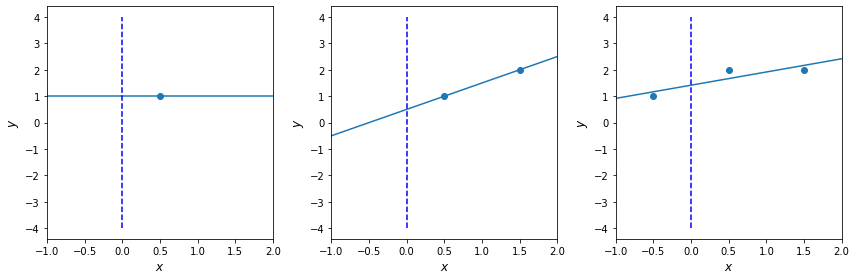

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def fit_plot(X_train, y_train, knots, xlim, ax, ylim=None, alpha=None, label="", alphac=None):    
    X_plt = np.linspace(xlim[0], xlim[1], 100)
    reg = QuadraticSplineRegression(knots=knots, alpha=alpha, alphac=alphac)
    reg.fit(X_train, y_train)
    ax.scatter(X_train, y_train)
    ax.plot(X_plt, reg.predict(X_plt), label=label)
    #print(reg.beta)
    #print(reg.bias)
    for knot in knots:
        ax.plot([knot, knot],[-4,4], linestyle="--", color="blue")
    ax.set_xlabel("$x$", fontsize="large")
    ax.set_ylabel("$y$", fontsize="large")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,2), knots=[0], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,2), knots=[0], ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,2], xlim=(-1,2), knots=[0], ax=ax3)
plt.tight_layout()
plt.show()

## 2 knots

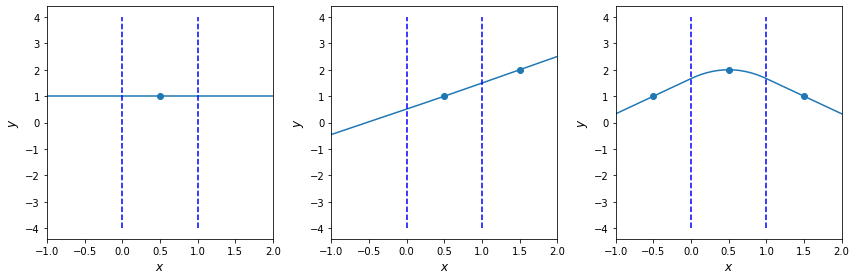

In [4]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,2), knots=[0,1], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,2), knots=[0,1],ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,1], xlim=(-1,2), knots=[0,1],ax=ax3)
plt.tight_layout()
plt.show()

## 3 knots

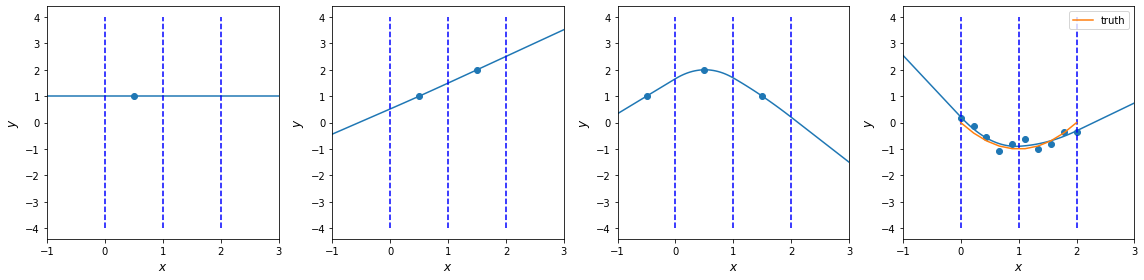

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
fit_plot(X_train = [0.5], y_train = [1], xlim=(-1,3), knots=[0,1,2], ax=ax1)
fit_plot(X_train = [0.5, 1.5], y_train = [1,2], xlim=(-1,3), knots=[0,1,2],ax=ax2)
fit_plot(X_train = [-0.5, 0.5, 1.5], y_train = [1,2,1], xlim=(-1,3), knots=[0,1,2],ax=ax3)
X=np.linspace(0,2,10)
y=X*X-2*X
fit_plot(X_train = X, y_train=y+0.2*np.random.randn(10), xlim=(-1,3), knots=[0,1,2],ax=ax4)
ax4.plot(X, y, label="truth")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## L2正则化参数 $\alpha$ 
$\alpha$ 倾向于比较小的样条函数系数，但不包含常数项。

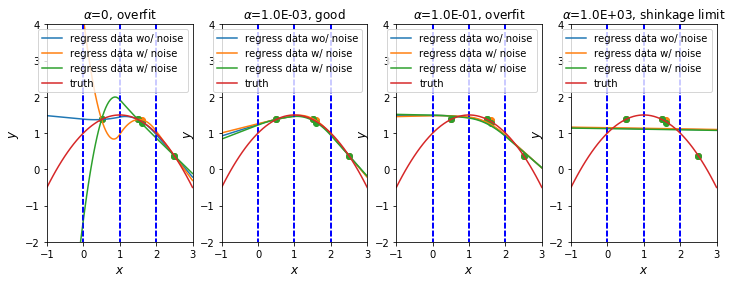

In [6]:
def f(x):
    x = np.array(x)
    return -1/2*x*x +x + 1
x = [0.5, 1.5, 1.6, 2.5]
y = f(x)
y_with_noise1 = y + [0,0, 0.05,0]
y_with_noise2 = y + [0,0,-0.05,0]

fig = plt.figure(figsize=(12,4))

for i in range(4):
    ax = fig.add_subplot(1,4,1+i)
    if i == 0:
        alpha = 0
        ax.set_title(r"$\alpha$=0, overfit")
    elif i == 1:
        alpha = 1E-3
        ax.set_title(r"$\alpha$=%.1E, good"%alpha)
    elif i == 2:
        alpha = 0.1
        ax.set_title(r"$\alpha$=%.1E, overfit"%alpha)
    elif i == 3:
        alpha = 1000
        ax.set_title(r"$\alpha$=%.1E, shinkage limit"%alpha)
        
    fit_plot(X_train = x, y_train =y, xlim=(-1,3),ylim=(-2,4), knots=[0,1,2], alpha=alpha, ax=ax, label="regress data wo/ noise")
    fit_plot(X_train = x, y_train =y_with_noise1, xlim=(-1,3),ylim=(-2,4), knots=[0,1,2],alpha=alpha,  ax=ax, label="regress data w/ noise")
    fit_plot(X_train = x, y_train =y_with_noise2, xlim=(-1,3),ylim=(-2,4), knots=[0,1,2],alpha=alpha,  ax=ax, label="regress data w/ noise")
    ax.plot(np.linspace(-1,3), f(np.linspace(-1,3)), label="truth")
    ax.legend()


plt.show()

## 光滑正则化参数$\alpha_c$ 
$\alpha_c$对函数的曲率进行惩罚。

对于一维函数曲率为
$$
\int dx (f'')^2  = \sum_{i\geq 2} 4(\xi_{j+1} - \xi_{j})\beta_{i+1}^2
$$
非常类似于L2正则化，但是对线性项, 没有惩罚。

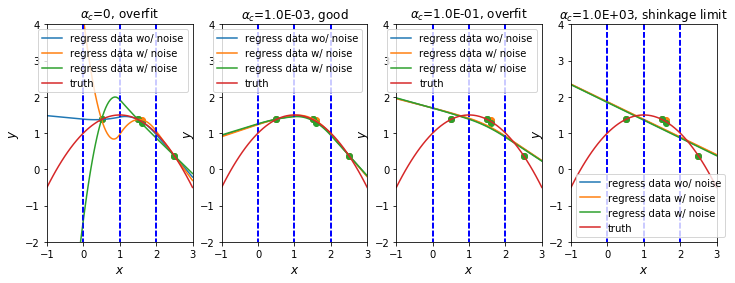

In [7]:
fig = plt.figure(figsize=(12,4))

for i in range(4):
    ax = fig.add_subplot(1,4,1+i)
    if i == 0:
        alpha = 0
        ax.set_title(r"$\alpha_c$=0, overfit")
    elif i == 1:
        alpha = 1E-3
        ax.set_title(r"$\alpha_c$=%.1E, good"%alpha)
    elif i == 2:
        alpha = 0.1
        ax.set_title(r"$\alpha_c$=%.1E, overfit"%alpha)
    elif i == 3:
        alpha = 1000
        ax.set_title(r"$\alpha_c$=%.1E, shinkage limit"%alpha)
        
    fit_plot(X_train = x, y_train =y, xlim=(-1,3),ylim=(-2,4), knots=[0,1,2], alphac=alpha, ax=ax, label="regress data wo/ noise")
    fit_plot(X_train = x, y_train =y_with_noise1, xlim=(-1,3),ylim=(-2,4), knots=[0,1,2],alphac=alpha,  ax=ax, label="regress data w/ noise")
    fit_plot(X_train = x, y_train =y_with_noise2, xlim=(-1,3),ylim=(-2,4), knots=[0,1,2],alphac=alpha,  ax=ax, label="regress data w/ noise")
    ax.plot(np.linspace(-1,3), f(np.linspace(-1,3)), label="truth")
    ax.legend()

plt.show()

## 高密度knots


如果knots密度很高，且正则化参数很弱，显然曲线自由度会很高，曲线会穿过所有数据点。

对于均匀的knots，对于曲率正则化，惩罚项为
$$
~\sim \alpha_c \sum_{j\geq 2} \beta_j^2
$$
对于L2正则化，惩罚项为
$$
~\sim \alpha \sum_{j\geq 1} \beta_j^2
$$

如果knots密度很高，且正则化参数很弱，且对于均匀的knots，L2正则化和曲率正则化的差别不大，因此两者在$N_{knots}\rightarrow \infty$时，拟合曲线应当有相同极限。
如果两者极限不一样，即$\beta_j \neq \hat{\beta_j}$，则$\sum_{j\geq 2} \beta_j^2 - \sum_{j\geq 2} \hat{\beta}_j^2 \sim O(N)$，其中$N$为样条数量，显然这不是L2正则化的最优点。于是在$N\rightarrow\infty$时，两种正则化的效果相同。



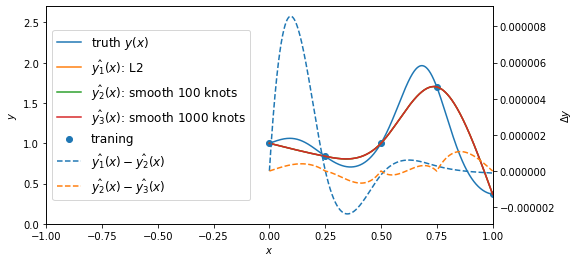

In [8]:
def f(X):
    return np.exp(X*np.cos(3*np.pi*X))
    
X_plt = np.linspace(0,1,1000)
X_train = np.linspace(0,1,5)

plt.figure(figsize=(8,4))
plt.plot(X_plt, f(X_plt), label=r"truth $y(x)$")
plt.scatter(X_train, f(X_train), label="traning")

qsr1=QuadraticSplineRegression(knots=np.linspace(0, 1.0, 1000), alpha=1E-10, alphac=0)
qsr2=QuadraticSplineRegression(knots=np.linspace(0, 1.0, 1000), alpha=0, alphac=1E-10)
qsr3=QuadraticSplineRegression(knots=np.linspace(0, 1.0, 2000), alpha=0, alphac=1E-10)
    
for k in qsr1.knots[0]:
    #plt.plot([k,k], [0,3], linestyle="--", color="green")
    pass
    
qsr1.fit(X_train, f(X_train))
qsr2.fit(X_train, f(X_train))
qsr3.fit(X_train, f(X_train))

plt.plot(X_plt, qsr1.predict(X_plt), label=r"$\hat{y_1}(x)$: L2")
plt.plot(X_plt, qsr2.predict(X_plt), label=r"$\hat{y_2}(x)$: smooth 100 knots")
plt.plot(X_plt, qsr3.predict(X_plt), label=r"$\hat{y_3}(x)$: smooth 1000 knots")
plt.ylabel(r"$y$")
plt.xlabel("$x$")
plt.ylim((0,2.7))
handlers, labels = plt.gca().get_legend_handles_labels()

plt.sca(plt.gca().twinx())
plt.plot(X_plt, qsr1.predict(X_plt) - qsr2.predict(X_plt), label="$\hat{y_1}(x) - \hat{y_2}(x)$", linestyle="--")
plt.plot(X_plt, qsr2.predict(X_plt) - qsr3.predict(X_plt), label="$\hat{y_2}(x) - \hat{y_3}(x)$", linestyle="--")
plt.ylabel(r"$\Delta y$")
handlers2, labels2 = plt.gca().get_legend_handles_labels()

handlers += handlers2
labels += labels2
plt.xlim((-1,1))
plt.legend(handlers, labels, loc="center left", fontsize="large")
plt.show()


## $\exp(x\cos(3\pi x))$

这里回归退化成了插值。
这里的最大误差为0.008，比高斯核的插值方法的最大误差0.027好了大概3倍。
(see https://en.wikipedia.org/wiki/Radial_basis_function_interpolation)

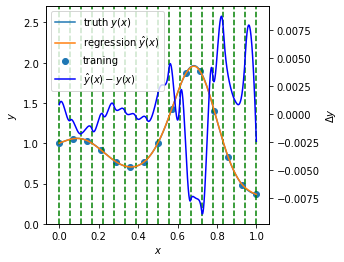

In [9]:
def f(X):
    return np.exp(X*np.cos(3*np.pi*X))
    
X_plt = np.linspace(0,1,1000)
X_train = np.linspace(0,1,15)

plt.figure(figsize=(4,4))
plt.plot(X_plt, f(X_plt), label=r"truth $y(x)$")
plt.scatter(X_train, f(X_train), label="traning")

qsr=QuadraticSplineRegression(knots=np.linspace(0, 1.0, 19), alpha=5E-3)
#qsr=QuadraticSplineRegression(knots=np.linspace(0, 1.0, 19), alpha=1E-6, alphac=1E-7)

for k in qsr.knots[0]:
    plt.plot([k,k], [0,3], linestyle="--", color="green")
    
qsr.fit(X_train, f(X_train))
plt.plot(X_plt, qsr.predict(X_plt), label=r"regression $\hat{y}(x)$")
plt.ylabel(r"$y$")
plt.xlabel("$x$")
plt.ylim((0,2.7))
handlers, labels = plt.gca().get_legend_handles_labels()

plt.sca(plt.gca().twinx())
plt.plot(X_plt, qsr.predict(X_plt) - f(X_plt), color="blue", label="$\hat{y}(x) - y(x)$")
plt.ylabel(r"$\Delta y$")
handlers2, labels2 = plt.gca().get_legend_handles_labels()

handlers += handlers2
labels += labels2
plt.legend(handlers, labels, loc="upper left")
plt.show()


# 2D fit

In [10]:
from mpl_toolkits.mplot3d import Axes3D
def fit_plot3d_reg(X_train, y_train, knots, reg, X_test = None, y_test = None,\
                   xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20):
    y_train =np.array(y_train)
    X_train = np.array(X_train)
    
    reg.fit(X_train, y_train)
    
    
    
    x_plt = np.linspace(xlim[0], xlim[1], 100)
    y_plt = np.linspace(ylim[0], ylim[1], 100)
    xx, yy = np.meshgrid(x_plt, y_plt)
    #print(reg.beta)
    #print(reg.bias)
    #print(X_train[:,0])
    #print(X_train[:,1])
    #print(y_train)
    yhat_train = reg.predict(X_train)
    up = y_train > yhat_train
    down = y_train <= yhat_train
    
    if np.any(up):
        ax.scatter(X_train[:,0][up], X_train[:,1][up], y_train[up], s=sz, color="red")
    if np.any(down):
        ax.scatter(X_train[:,0][down], X_train[:,1][down], y_train[down], s=sz, color="green")
    
    from matplotlib import cm
    ax.plot_surface(xx, yy, reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(100,100), alpha=0.3, cmap=cm.coolwarm)
    
    for k1 in knots[0]:
        ax.plot([k1, k1],[-1,1],[0,0], linestyle="--", color="blue")
    for k2 in knots[1]:
        ax.plot([-1, 1],[k2, k2],[0,0], linestyle="--", color="blue")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    mse = np.sqrt(np.square(y_train-reg.predict(X_train)).mean())
    if X_test is not None and X_test is not None:
        mse2 = np.sqrt(np.square(y_test-reg.predict(X_test)).mean())
        ax.set_title("RMSE(Training) = %.1E,\nRMSE(Test) = %.1E"%(mse, mse2))
    else:
        ax.set_title("RMSE(Training) = %.1E"%(mse))
    
    return reg


## 1 knot

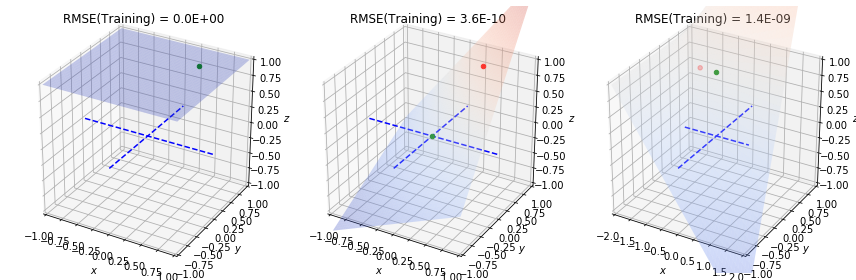

In [11]:
def fit_plot3d_qsr(X_train, y_train, knots, X_test=None, y_test=None, \
                   xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20, alpha=None, alphac=None):    
    reg = QuadraticSplineRegression(knots=knots, alpha=alpha, alphac=alphac)
    return fit_plot3d_reg(X_train, y_train, knots, reg, X_test=X_test, y_test = y_test,\
                          xlim=xlim, ylim=ylim, zlim=zlim, ax=ax, sz=sz)




    
fig=plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1, projection="3d")
fit_plot3d_qsr(X_train = [[1/2,1/2]], y_train = [1], xlim=(-1,1), knots=[[0],[0]], ax=ax1)
ax2 = fig.add_subplot(1,3,2, projection="3d")
fit_plot3d_qsr(X_train = [[0,0], [1/2,1/2]], y_train = [0, 1], xlim=(-1,1), knots=[[0],[0]], ax=ax2)
ax3 = fig.add_subplot(1,3,3, projection="3d")
fit_plot3d_qsr(X_train = [[-1/2,0], [0,0], [1/2,1/2]], y_train = [1, 1, 2], xlim=(-2,2), knots=[[0],[0]], ax=ax3)
plt.tight_layout()
plt.show()


## 3x3 knots

### The basis functions

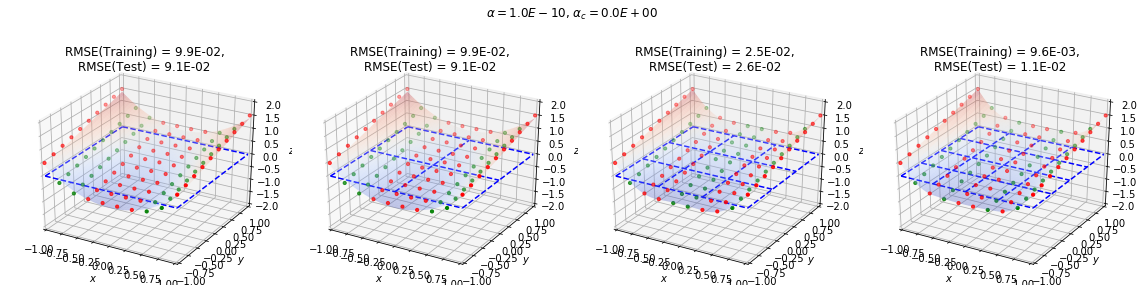

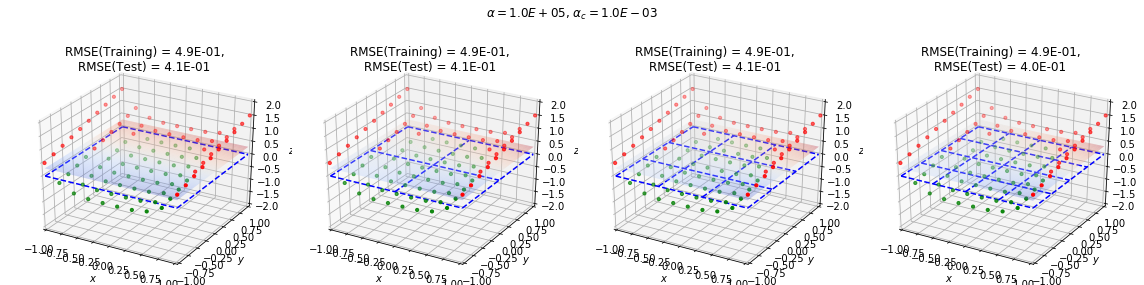

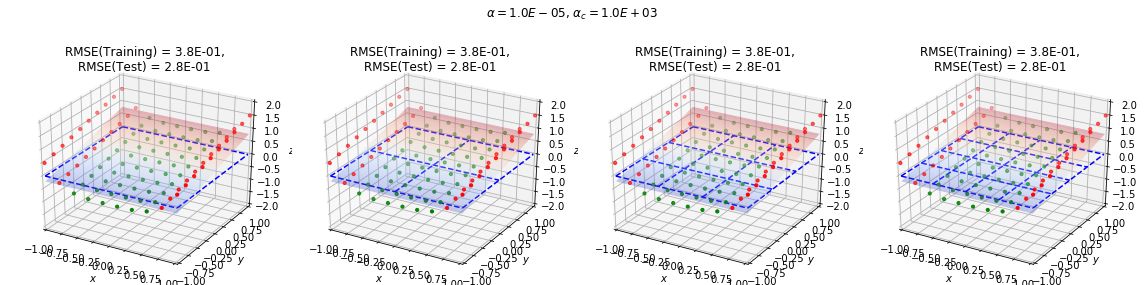

In [12]:
def f21(X):
    #return X[:,0]*X[:,0] + 1/2*X[:,1]**3 + 0*np.random.randn(X.shape[0])
    return X[:,0]**4 + 1/2*X[:,1] + 0*np.random.randn(X.shape[0])


Ndata=100*100
N=2
N_grid=10

X_rnd=2*np.random.rand(Ndata,N)-1

X_grid=np.zeros((N_grid*N_grid, N))
c=0

x1=np.linspace(-1,1,N_grid)
x2=np.linspace(-1,1,N_grid)

for i in range(N_grid):
    for j in range(N_grid):
        X_grid[c,0] = x1[i]
        X_grid[c,1] = x1[j]
        c += 1

X_train = X_grid     
y_train = f21(X_train)
X_test = X_rnd
y_test = f21(X_test)


fig=plt.figure(figsize=(16,4))
for i in range(4):
    ax1 = fig.add_subplot(1,4,1+i, projection="3d")
    reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                         zlim=(-2,2), knots=[np.linspace(-1,1,2+i)]*2, ax=ax1, sz=10, alpha=1E-10)
fig.suptitle(r"$\alpha=%.1E$, $\alpha_c=%.1E$"%(reg.alpha, reg.alphac))
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()


fig=plt.figure(figsize=(16,4))
for i in range(4):
    ax1 = fig.add_subplot(1,4,1+i, projection="3d")
    reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                         zlim=(-2,2), knots=[np.linspace(-1,1,2+i)]*2, ax=ax1, sz=10, alpha=1E5,alphac=1E-3)
fig.suptitle(r"$\alpha=%.1E$, $\alpha_c=%.1E$"%(reg.alpha, reg.alphac))
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()

fig=plt.figure(figsize=(16,4))
for i in range(4):
    ax1 = fig.add_subplot(1,4,1+i, projection="3d")
    reg = fit_plot3d_qsr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                         zlim=(-2,2), knots=[np.linspace(-1,1,2+i)]*2, ax=ax1, sz=10, alpha=1E-5,alphac=1E3)
fig.suptitle(r"$\alpha=%.1E$, $\alpha_c=%.1E$"%(reg.alpha, reg.alphac))
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()


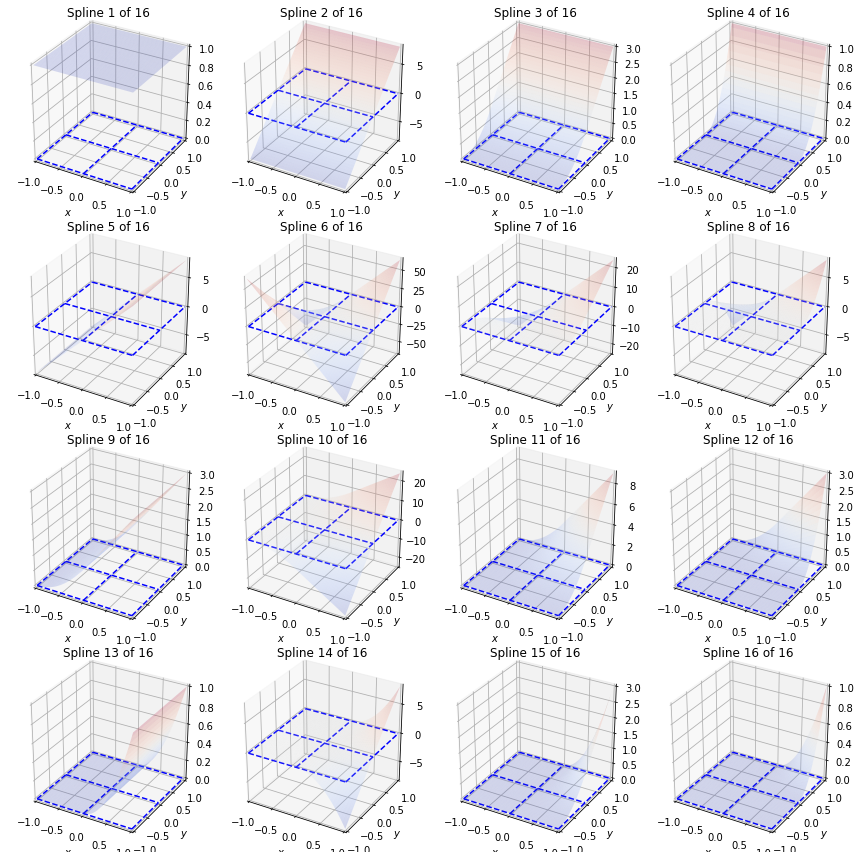

In [13]:
def fit_plot3d_i(knots, i, xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), ax=None, sz=20):    
    
    x_plt = np.linspace(xlim[0], xlim[1], 100)
    y_plt = np.linspace(ylim[0], ylim[1], 100)
    xx, yy = np.meshgrid(x_plt, y_plt)
    reg = QuadraticSplineRegression(knots=knots)
    #beta = reg.beta[i]
    reg.beta = np.zeros(reg.N_splines)
    reg.beta[i] = 1
    #print(reg.beta)
    #print(reg.bias)
    
    from matplotlib import cm
    ax.plot_surface(xx, yy, reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(100,100), alpha=0.2, cmap=cm.coolwarm)
    
    for k1 in knots[0]:
        ax.plot([k1, k1],[-1,1],[0,0], linestyle="--", color="blue")
    for k2 in knots[1]:
        ax.plot([-1, 1],[k2, k2],[0,0], linestyle="--", color="blue")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.set_zlim(zlim)
    ax.set_title("Spline %d of %d"%(i+1, reg.N_splines))
    
    return reg


fig=plt.figure(figsize=(12,12))

for i in range(16):

    ax1 = fig.add_subplot(4,4,i+1, projection="3d")
    fit_plot3d_i(i=i, zlim=(-2,2), knots=[np.linspace(-1,1,3)]*2, ax=ax1, sz=10)

plt.tight_layout()
plt.show()


# 5D fit on grid vs. random locations

No. of splines  3125
No. of training points  3125


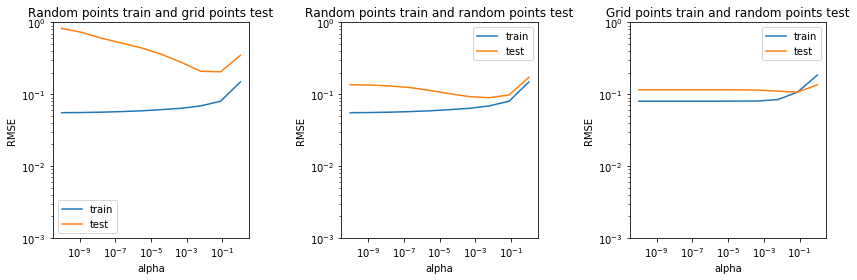

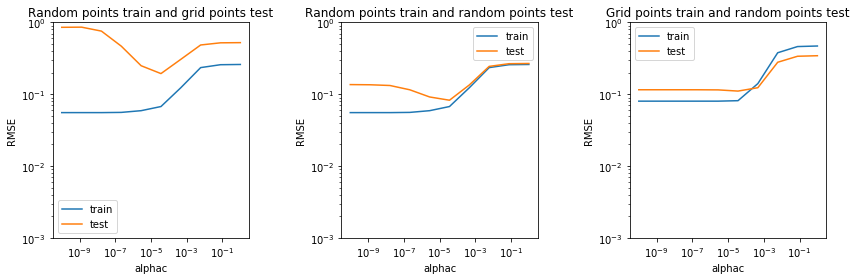

In [14]:
N=5


def plot_err_vs_alpha(X_train, X_test, ax, par="alpha"):

    y_train = f21(X_train)
    y_test = f21(X_test)
    
    mse_train=[]
    mse_test=[]
    alphas=np.power(10, np.linspace(-10, 0, 10))
    
    qsr = QuadraticSplineRegression(knots=[np.linspace(-1,1,3)]*N)
    for alpha in alphas:
        #print("alpha", alpha)
        if par == "alpha":
            qsr.alpha = alpha
        else:
            qsr.alphac = alpha
            
        qsr.fit(X_train, y_train)
        mes_1 = np.sqrt(np.square(y_test - qsr.predict(X_test)).mean())
        mes_2 = np.sqrt(np.square(y_train - qsr.predict(X_train)).mean())
        mse_test.append(mes_1+1E-100)
        mse_train.append(mes_2+1E-100)
        

    
    ax.plot(alphas, mse_train, label="train")
    ax.plot(alphas, mse_test, label="test")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"%s"%par)
    ax.set_ylabel("RMSE")
    ax.legend()
    ax.set_ylim((10E-4,10E-1))
    return ax


Ngrid = 5
Ndata = Ngrid**N


X_rnd1 = 2 * np.random.rand(Ndata, N) - 1
X_rnd2 = 2 * np.random.rand(Ndata, N) - 1
X_grid = np.zeros((Ngrid**N, N))

x1=np.linspace(-1,1, Ngrid)

c=0
for i in range(Ngrid):
    for j in range(Ngrid):
        for k in range(Ngrid):
            for l in range(Ngrid):
                for m in range(Ngrid):
                    X_grid[c,0] = x1[i]
                    X_grid[c,1] = x1[j]
                    X_grid[c,2] = x1[k]
                    X_grid[c,3] = x1[l]
                    X_grid[c,4] = x1[m]
                    c += 1

                    
qsr = QuadraticSplineRegression(knots=[np.linspace(-1,1,4)]*N)
print("No. of splines ", qsr.N_splines)
print("No. of training points ", Ndata)



fig = plt.figure(figsize=(12,4))
ax = plot_err_vs_alpha(X_rnd1, X_grid, ax=fig.add_subplot(1,3,1), par="alpha")                       
ax.set_title("Random points train and grid points test")
ax = plot_err_vs_alpha(X_rnd1, X_rnd2, ax=fig.add_subplot(1,3,2), par="alpha")
ax.set_title("Random points train and random points test")
ax = plot_err_vs_alpha(X_grid, X_rnd2, ax=fig.add_subplot(1,3,3), par="alpha")
ax.set_title("Grid points train and random points test")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,4))
ax = plot_err_vs_alpha(X_rnd1, X_grid, ax=fig.add_subplot(1,3,1), par="alphac")                       
ax.set_title("Random points train and grid points test")
ax = plot_err_vs_alpha(X_rnd1, X_rnd2, ax=fig.add_subplot(1,3,2), par="alphac")
ax.set_title("Random points train and random points test")
ax = plot_err_vs_alpha(X_grid, X_rnd2, ax=fig.add_subplot(1,3,3), par="alphac")
ax.set_title("Grid points train and random points test")
plt.tight_layout()
plt.show()


# 嵌套插值回归

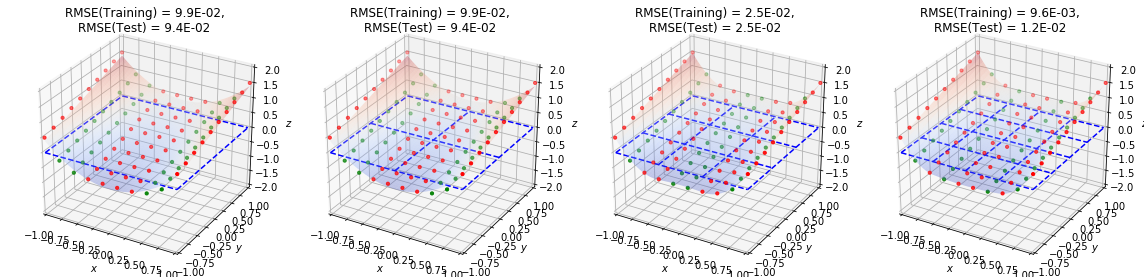

In [13]:
def fit_plot3d_nr(X_train, y_train, knots, X_test=None, y_test=None, xlim=(-1,1), ylim=(-1,1), zlim=(-1,1),\
                  ax=None, sz=20, alpha=None):    
    qsrs = [QuadraticSplineRegression(knots=knots) for _ in range(2)]
    reg = NestingRegression(qsrs)
    return fit_plot3d_reg(X_train=X_train, y_train=y_train, reg=reg, knots=knots*2, X_test=X_test, y_test=y_test,\
                          xlim=xlim, ylim=ylim, zlim=zlim, ax=ax, sz=sz)
    

Ndata=100
N=2
N_grid=10

X_rnd=2*np.random.rand(Ndata, N)-1

X_grid=np.zeros((N_grid*N_grid, N))
c=0

x1=np.linspace(-1,1,N_grid)
x2=np.linspace(-1,1,N_grid)

for i in range(N_grid):
    for j in range(N_grid):
        X_grid[c,0] = x1[i]
        X_grid[c,1] = x2[j]
        c += 1
        
X_train = X_grid     
y_train = f21(X_train)
X_test = X_rnd
y_test = f21(X_test)


fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,4,1, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,2)], ax=ax1, sz=10)
ax2 = fig.add_subplot(1,4,2, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,3)], ax=ax2, sz=10)
ax3 = fig.add_subplot(1,4,3, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,4)], ax=ax3, sz=10)
ax4 = fig.add_subplot(1,4,4, projection="3d")
reg = fit_plot3d_nr(X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test,\
                    zlim=(-2,2), knots=[np.linspace(-1,1,5)], ax=ax4, sz=10)
plt.tight_layout()
plt.show()



# Test

In [15]:
def test_get_values():
    # Test get_values
    splines1d = QuadraticSpline1D(knots=[0, 1])
    assert splines1d.N_splines == 3
    #print("v", splines1d.get_values([2]))
    assert np.allclose(splines1d.get_values([2]), [[1,2*3*3,(2-1)*(2*2-0-1)]])

def test_get_M1(knots, dop=False):
    splines1d = QuadraticSpline1D(knots=knots)
    assert splines1d.N_splines == len(knots) + 1
    
    x1 = np.linspace(knots[0], knots[-1], 10000)
    x2 = np.linspace(knots[0], knots[-1], 10000)
    dx = (knots[-1] - knots[0])/10000
    
    s1 = splines1d.get_values(x1)
    s2 = splines1d.get_values(x2)
    
    M = splines1d.get_M0()
    m = np.zeros((splines1d.N_splines, splines1d.N_splines))
    for i in range(splines1d.N_splines):
        for j in range(splines1d.N_splines):
            m[i,j] = (s1[:,i]*s2[:,j]).sum()*dx
            if dop:
                print("%d %d %f"%(i,j,m[i,j]))
                print("%d %d %f"%(i,j,M[i,j]))
    assert np.allclose(m, M, rtol=1E-1, atol=1E-1)
        
def test_get_M():
    test_get_M1([0,1])
    test_get_M1([0,2])
    test_get_M1([0,3])
    test_get_M1([0,1,2])
    test_get_M1([0,1,3])
    test_get_M1([0,1,3,5])

def test_get_Omega():
    qsr=QuadraticSplineRegression(knots=[[0,1,2],[1,2,3]])
    for splines_1D in qsr.splines:        
        M2 = qsr.splines[0].get_M2()
        U,S,VT = np.linalg.svd(M2)
        assert np.all(S >= -1E-10)
        
    Omega = qsr.get_Omega()
    U,S,VT = np.linalg.svd(Omega)
    assert np.all(S >= -1E-10)
    #print(S)
    
def cal_average_curvature_numerically_1d(qsr):
    x_min = qsr.knots[0][0]
    x_max = qsr.knots[0][-1]
    
    
    Dx = x_max - x_min
    dx = Dx/1000
    x = np.linspace(x_min-Dx/2000, x_max+Dx/2000, 1001)
    
    yhat = qsr.predict(x)    
    dxx = (yhat[0:-2] + yhat[2:1001] - 2*yhat[1:-1])/dx**2 
    
    #plt.plot(x, yhat)
    #plt.plot(x, yhat)
    #plt.plot(x[1:-2], dxx)
    return np.square(dxx).sum()*dx

def test_curvature_1d_detail(knots, p=False):
    qsr = QuadraticSplineRegression(knots=knots)
    qsr.beta = np.array(np.random.randn(qsr.N_splines))
    c1 = cal_average_curvature_numerically_1d(qsr)
    c2 = qsr.cal_curvature()
    if p:
        print(c1)
        print(c2)
        print(qsr.get_Omega())
    assert np.allclose(c1, c2, rtol=1E-2, atol=1E-2)
    
def cal_average_curvature_numerically_2d(qsr, p=False):
    knots = qsr.knots
    
    x_min = knots[0][0]
    x_max = knots[0][-1]
    y_min = knots[1][0]
    y_max = knots[1][-1]
    
    
    Dx = x_max - x_min
    Dy = y_max - y_min

    N=1000
    x = np.linspace(x_min-Dx/(2*N), x_max+Dx/(2*N), N+1)
    y = np.linspace(y_min-Dy/(2*N), y_max+Dy/(2*N), N+1)
    dx = Dx/N
    dy = Dy/N
    
    xx, yy = np.meshgrid(x, y)
    
    #print(xx)
    yhat = qsr.predict(np.c_[xx.ravel(), yy.ravel()])
    yhat = yhat.reshape(N+1, N+1)    
    
    xx_ = xx[1:-1,1:-1]
    yy_ = yy[1:-1,1:-1]
    
    # inner is x
    dyy = (yhat[0:-2,1:-1] + yhat[2:N+1,1:-1] - 2*yhat[1:-1,1:-1])/dy**2    
    dxx = (yhat[1:-1,0:-2] + yhat[1:-1,2:N+1] - 2*yhat[1:-1,1:-1])/dx**2
    dxy = (yhat[0:-2,0:-2] + yhat[2:N+1, 2:N+1] - yhat[2:N+1,0:-2] - yhat[0:-2,2:N+1])/(4*dx*dy)
    
    if p:
        fig = plt.figure()
        ax =fig.add_subplot(1,1,1,projection="3d")
        ax.plot_surface(xx_, yy_, dyy)
        ax.plot_surface(xx_, yy_, dxx)
        ax.plot_surface(xx_, yy_, dxy)
        ax.plot_surface(xx, yy, yhat)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(30, 20)
        print("xx", (dxx**2).sum()*dx*dy)
        print("yy", (dyy**2).sum()*dx*dy)
        print("xy", (dxy**2).sum()*dx*dy)
        
    c = ((dxx**2).sum()+(dyy**2).sum() + 2*(dxy**2).sum())*dx*dy
    return c

    
def test_curvature_2d_detail(knots, p=False):
    qsr = QuadraticSplineRegression(knots=knots)
    if p:
        print("splines:", qsr.N_splines)
        
    qsr.beta = np.array(np.random.randn(qsr.N_splines))
    if p:
        qsr.beta = np.array([0,0,0,0, 0,0,0,1, 0,0,0,0])
    
    c1 = cal_average_curvature_numerically_2d(qsr,p)
    c2 = qsr.cal_curvature()
    if p:
        print("num", c1)
        print("ana", c2)
        print("M1[1]", qsr.splines[0].get_M1())
        print("M1[0]", qsr.splines[1].get_M1())
        print("Omega", qsr.get_Omega())
    assert np.allclose(c1, c2, rtol=1E-2, atol=1E-2)
    

def test_curvature_1d():
    test_curvature_1d_detail([0,1])
    test_curvature_1d_detail([0,2])
    test_curvature_1d_detail([0,1,2])
    test_curvature_1d_detail([0,1,3])
    test_curvature_1d_detail([0,2,3])
    test_curvature_1d_detail([-2,2,3,7])
    
def test_curvature_2d():
    test_curvature_2d_detail([[0,1],[0,1]])
    test_curvature_2d_detail([[0,1],[0,2]])
    test_curvature_2d_detail([[0,2],[0,2]])
    test_curvature_2d_detail([[0,1],[0,1,2]])
    test_curvature_2d_detail([[0,1,2],[0,1]])
    test_curvature_2d_detail([[0,1,3],[0,2,3]])
    test_curvature_2d_detail([[0,1,3],[0,2,3,6]])
    #test_curvature_2d_detail([[0,1],[0,1,2]], p=True)
    
test_get_values()
test_get_M()
test_get_Omega()
test_curvature_1d()
test_curvature_2d()

# Benchmark

In [17]:
N=5
def f6(X):
    return X[:,0] + X[:,1]**3   \
    + 0.25*1/(1+0.2*X[:,2]) + 0.25*1/(1+0.3*X[:,3])/(1+0.3*X[:,4])


X_train = 2 * np.random.rand(10*1000, N) - 1
X_test = 2 * np.random.rand(10*1000, N) - 1
y_train = f6(X_train) + 0.0 * np.random.randn(10*1000)


qsr1 = QuadraticSplineRegression(knots=[np.linspace(-1,1,4)]*N, alphac=0)
%timeit -r1 -n1 qsr1.get_H(X_train)
%timeit -r1 -n1 qsr1.pre_fit(X_train)
%timeit -r1 -n1 qsr1.update_for_y(y_train)
%timeit -r1 -n1 qsr1.fit(X_train, y_train)
%timeit -r1 -n1 qsr1.predict(X_test)
qsr2 = QuadraticSplineRegression(knots=[np.linspace(-1,1,4)]*N, alpha=1E-10, alphac=1E-6)
%timeit -r1 -n1 qsr2.get_Omega()
%timeit -r1 -n1 qsr2.fit(X_train, y_train) # reuse the get_Omega()
%timeit -r1 -n1 qsr2.predict(X_test)

368 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
15.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
360 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
358 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# 附录

## M0 矩阵
$$
M_{ij}^{(0)} \equiv \int_{\xi_0}^{\xi_{max}} dx f_i(x) f_j(x)
$$


对于
$$
M_{0,0} = \int_{\xi_0}^{\xi_{max}} dx 1 = \xi_{max} - \xi_0
$$

$$
M_{0,1} = \int_{\xi_0}^{\xi_{max}} dx x = 1/2(\xi_{max} - \xi_0)(\xi_{max} + \xi_0)
$$


$$
M_{0,j\geq2} = \int_{\xi_0}^{\xi_{max}} dx f_j(x) = 1/3 [(\xi_{max} - \xi_{j})^3 -  (\xi_{max} - \xi_{j+1})^3]
$$

$$
M_{1,1} = \int_{\xi_0}^{\xi_{max}} dx x^2 = 1/3 (\xi_{max}^3 - \xi_0^3)
$$

$$
M_{1,j\geq2} = \int_{\xi_0}^{\xi_{max}} dx x f_j(x)
$$

$$
M_{1,j\geq2} = 1/4 [(\xi_{max} - \xi_i)^4 - (\xi_{max} - \xi_{i+1})^4]
+ 1/3 ((\xi_{max} - \xi_i)^3\xi_{i}
- (\xi_{max} - \xi_{i+1})^3\xi_{i+1})
$$

$$
M_{1,j\geq2} = -1/12 [(\xi_{max} - \xi_i)^4 - (\xi_{max} - \xi_{i+1})^4]
+ 1/3 ((\xi_{max} - \xi_i)^3
- (\xi_{max} - \xi_{i+1})^3)\xi_{max}
$$


$$
M_{2 \leq i \lt j, j} = \int_{\xi_0}^{\xi_{max}} dx (a_i+b_i x)f_j(x)
= a M_{0j} + b M_{1j}
$$

$$
M_{1,j\geq2} = f_i(\xi_j)(1/3)(\xi_{i+1} - \xi_i)^3 +  b_i (1/4)(\xi_{i+1} - \xi_i)^4
+
b_i b_j(1/3)(\xi_{max}-\xi_{j+1})^3
+ (b_i f_j(\xi_{j+1})  + f_i(x_{j+1}) b_j)(1/2)(\xi_{max}-\xi_{j+1})^2
+ f_j(\xi_{j+1}) f_i(x_{j+1})  (\xi_{max} - \xi_{j+1})
$$

其中


$$
b_i=2 (\xi_{i+1}-\xi_i)
$$
$$
b_j=2 (\xi_{j+1}-\xi_j)
$$

最后

$$
M_{2 \leq i, j = i} = \int_{\xi_0}^{\xi_{max}} dx f^2_j(x)
$$

$$
M_{2 \leq i, j = i} = \int_{\xi_0}^{\xi_{max}} dx (x-\xi_{i})^4 I(\xi_i < x <\xi_{i+1}) + (\xi_i-\xi_{i+1})^2 (2x - \xi_i -\xi_{i+1})^2  I(x >\xi_{i+1})
$$

$$
first term = 1/5 (\xi_{i+1}-\xi_i)^5
$$

$$
second term
=
(\xi_i-\xi_{i+1})^2 \int_{\xi_{i+1}}^{\xi_{max}} dx (2x - \xi_i -\xi_{i+1})^2 
$$


$$
second term
=
(\xi_i-\xi_{i+1})^2 \int_{0}^{\xi_{max}-\xi_{i+1}} dx (2x + \xi_{i+1}- \xi_i)^2 
$$

$$
second term
=
(\xi_i-\xi_{i+1})^2 \int_{0}^{\xi_{max}-\xi_{i+1}}  dx (4x^2 + 4x(\xi_{i+1}- \xi_i) + (\xi_{i+1}- \xi_i) ^2)
$$

$$
second term
=
(\xi_i-\xi_{i+1})^2\left[4/3 (\xi_{max}-\xi_{i+1})^3
+ 4/2(\xi_{i+1}- \xi_i)(\xi_{max}-\xi_{i+1})^2
+ (\xi_{i+1}- \xi_i) ^2(\xi_{max}-\xi_{i+1})
\right]
$$




## M1

$$
M^{(1)}_{ij} \equiv \int_{\xi_0}^{\xi_{max}} dx f'_i(x) f'_j(x)
$$

$$
M_{0*}=0
$$

$$
M_{11}=\xi_{max} - \xi_0
$$

$$
M_{1,j>=2}= f_j(\xi_{max})
$$

$$
M_{i\geq 2, j > i}= 2(\xi_{i+1}-\xi_i)f_j(\xi_{max})
$$

$$
M_{i\geq 2, j =i}= 4/3 (\xi_{j+1}-\xi_j)^3 + 4(\xi_{j+1}-\xi_j)^2(\xi_{max}-\xi_{j+1})
$$



## M2

$$
M^{(2)}_{ij} \equiv \int_{\xi_0}^{\xi_{max}} dx f''_i(x) f''_j(x)
$$

显然
$$
M_{00}=M_{1*}=M_{*1}=0
$$

显然对我们选择基矢来说$M_{ij}$是对角矩阵

$$
M^{(2)}_{ii} = 2(\xi_{j+1} - \xi_j)
$$



## 正交变换
证明在$\mathbf{x}$的正交变化下，下式不变
$$
\sum_{ij} (\partial_{i}\partial_j f(\mathbf{x}))^2
$$

证明：
设
$$
y = Ax,\quad x = A^T y
$$
其中
$$
A^T A = I
$$
则
$$
\partial_{y_j} f
=
\sum_{k} (\partial_{y_j} x_k) \partial_{x_k} f
=
\sum_{k} A_{jk} \partial_{x_k} f
$$

$$
\partial_{y_i}\partial_{y_j} f
=
A_{il} A_{jk} \partial_{x_l} \partial_{x_k} f
$$

设

$$
\sum_{ij} (\partial_{y_i}\partial_{y_j} f)^2 
= \sum_{ij} (\sum_{lk} A_{il} A_{jk} \partial_{x_l} \partial_{x_k} f)^2
$$

$$
\sum_{ij} (\partial_{y_i}\partial_{y_j} f)^2 
= \sum_{ij} \sum_{mn ls} A_{im} A_{jn} \partial_{x_m} \partial_{x_n} f A_{il} A_{js} \partial_{x_l} \partial_{x_s} f
$$

$$
\sum_{ij} (\partial_{y_i}\partial_{y_j} f)^2 
=  \sum_{mn}  \partial_{x_m} \partial_{x_n} f  \partial_{x_m} \partial_{x_n} f
=\sum_{ij} (\partial_{x_i}\partial_{x_j} f)^2 
$$
